In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import os
from sklearn.decomposition import PCA

import performance

## Eigen Portfolio for a Basket of Securities
### Introduction
**The idea of using Principal Component Analysis (PCA) to extract factors from a basket of securities is not new.** In this project, we borrow the idea mentioned in Dr. Marco Avellaneda's paper on statsitical arbitrage (https://math.nyu.edu/~avellane/AvellanedaLeeStatArb071108.pdf), and track the performance of eigen portfolios. This approach uses historical daily share price of N stocks going back M days, and applies PCA on the correlation matrix of standardized returns. 

**Specifically in this project, we use top 100 stocks from S&P 500 as our trading universe and one year as look back window as we construct the correlation matrix.** In particular, we do not wish to construct an eigen portfolio for S&P 100, but instead we wish to construct one for these 100 stocks. The reason is that we do not want to face the issue of survivorship bias in S&P 100 index, as it is not stationary in its holdings due to frequent additions and deletions of companies. A lot of articles and projects online are subjective to this bias, in the sense that many compare the eigen portfolio performance with the index performance over a long period of time (10+ years), without considering the changes in index composition.

**At the end of this project, we propose a simple trading strategy using three different eigen portfolios and rebalance monthly.** We also offer an overview of their performance. 

**The main takeaways of this project are:**
- PCA tends to cluster stocks based on their corresponding sectors/industries. This is observed across the first three components.
- The principal eigen portfolio behaves very similarly to an equally-weighted portfolio that rebalances monthly.
- Eigen portfolios based on the second or the third component gengerally have large volatility and high drawdown. 
- The downside of constructing an eigen portfolio is that it is a long/short portfolio, which carries the burden of potential over-leverage.

### Historical Dataset
**In this project, we define our static trading universe as 99 selected stocks from S&P 500, dating from 2015-07-06 to 2022-12-30.** To see the full list of tickers, please see SP 100 tickers.csv under yfinance data folder. We use dividend adjusted price for this exercise, and the dataset does not have missing price values.

In [2]:
data = pd.read_csv('./data/SP 100 Daily Data.csv')

In [3]:
# we drop ticker "DOW" due to its relatively short history (IPO in 2019).
# the remaining 99 stocks have full history from 2015-07-06 to 2022-12-30. This will be our backtesting period.
price_df = data.loc[(data['Type']=='Adj Close')&(data['Ticker']!='DOW')].pivot_table(
    index='Date',columns='Ticker',values='Price').dropna()
price_df.head(5)

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-06,28.502363,48.501278,42.805702,85.402023,80.500000,50.658947,2.47,122.848717,80.816475,21.802000,...,108.606392,80.376892,75.608353,34.138206,64.487411,32.283226,66.150368,44.779602,61.275925,57.053539
2015-07-07,28.432241,48.743011,43.210159,86.577705,80.589996,50.953796,2.09,123.556366,81.369545,21.836000,...,107.308372,81.629623,76.265388,34.036404,64.156082,32.427330,67.591255,44.628857,62.340416,57.288593
2015-07-08,27.726465,48.103146,42.384018,85.647682,79.989998,50.093777,2.01,121.107376,80.391045,21.485001,...,105.601402,80.051140,74.693176,33.410015,63.171547,32.344017,66.553185,43.835461,61.723682,56.666428
2015-07-09,27.160936,48.323540,42.332375,85.761742,80.470001,50.585217,1.98,120.312210,80.314476,21.719500,...,106.099281,80.385223,74.896545,33.637093,63.474472,32.121815,69.373047,44.033794,61.487137,56.410625
2015-07-10,27.887077,49.219345,42.969208,86.665428,80.589996,51.289616,1.96,122.530655,81.190880,22.175501,...,108.597511,81.696434,75.843018,34.012917,64.771408,32.635651,72.130936,44.493977,61.774376,56.839245


### Standardized Return Calculation
**We take a two-step approach to prepare the data for PCA analysis:**
- Calculate daily return based on adjusted close price
- Standardize returns so that different stock return volatilities are on the same scale. According to Dr. Avellaneda's paper, this can be achieved by applying the following,

*"Let us represent the stocks return data, on any given date $t_{0}$, going back $M+1$ days as a matrix
$$
R_{i,k} = \frac{S_{i,t_{0}-(k-1)\Delta t} - S_{i,t_{0}-k\Delta t}}{S_{i,t_{0}-k\Delta t}}, k=1,...,M, i=1,...,N,
$$
where $S_{i,t}$ is the price of stock $i$ at time $t$ adjusted for dividends and $\Delta t$=1/252. Since some stocks are more volatile than others, it is convenient to work with standardized returns,
$$
Y_{i,k} = \frac{R_{i,k}-\bar R_{i}}{\bar \sigma_{i}},
$$
where
$$
\bar R_{i} = \frac{1}{M}\Sigma_{k=1}^{M}R_{i,k},
$$
and
$$
\bar \sigma_{i}=\frac{1}{M-1}\Sigma_{k=1}^{M}(R_{i,k}-\bar R_{i})^{2}."
$$*

**As an example, we will perform this exercise on Jan 2nd, 2019, using 1-year look back window.** The choice of computed date and look back window is completely arbitrary, and we can theoratically slice historical data in a more intellectual way (e.g., use market regime models). This exercise tends to be illustrative.

**We compute and standardize the daily returns, and compute the correlation matrix.** Note that the dimension of correlation matrix is 99 by 99, which corresponds to the number of securities in our trading universe.

In [4]:
r_ik = (price_df/price_df.shift()-1).dropna()
r_ik_2018 = r_ik.loc['2018-01-01':'2018-12-31']

In [5]:
y_ik = (r_ik_2018 - r_ik_2018.mean())/r_ik_2018.std()

In [6]:
rho_ij = y_ik.corr()
rho_ij

Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,1.000000,0.317690,0.571417,0.616583,0.668566,0.256319,0.364347,0.469516,0.238687,0.661170,...,0.531642,0.497396,0.452200,0.371831,0.704296,0.131257,0.367740,0.414909,0.308229,0.435924
ABBV,0.317690,1.000000,0.499466,0.482000,0.381202,0.348676,0.243768,0.561312,0.255821,0.329813,...,0.481211,0.316601,0.365951,0.413913,0.428667,0.286413,0.358160,0.397480,0.302892,0.352451
ABT,0.571417,0.499466,1.000000,0.661578,0.648904,0.448019,0.431615,0.605471,0.288747,0.631586,...,0.616115,0.544342,0.529162,0.521047,0.697873,0.364411,0.444986,0.498296,0.416848,0.532085
ACN,0.616583,0.482000,0.661578,1.000000,0.651185,0.419122,0.364897,0.554175,0.319119,0.632018,...,0.600631,0.574645,0.471252,0.579401,0.738609,0.326685,0.326500,0.509593,0.390832,0.556482
ADBE,0.668566,0.381202,0.648904,0.651185,1.000000,0.293012,0.444407,0.542040,0.196694,0.759208,...,0.563153,0.468093,0.463128,0.378801,0.822348,0.064803,0.355742,0.367032,0.271530,0.389332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VZ,0.131257,0.286413,0.364411,0.326685,0.064803,0.206426,0.073811,0.355925,0.380223,0.076552,...,0.390145,0.291954,0.269004,0.403901,0.163152,1.000000,0.323103,0.309603,0.388951,0.286981
WBA,0.367740,0.358160,0.444986,0.326500,0.355742,0.314203,0.241488,0.513824,0.234164,0.336318,...,0.527248,0.425615,0.470183,0.437531,0.402015,0.323103,1.000000,0.363932,0.427708,0.375984
WFC,0.414909,0.397480,0.498296,0.509593,0.367032,0.467994,0.262095,0.485296,0.207002,0.402278,...,0.467775,0.464759,0.464354,0.745652,0.480814,0.309603,0.363932,1.000000,0.349756,0.487219


### Principal Component Analysis
**We perform PCA on the correlation matrix, and rank the eigenvalues in decreasing order.** We plot the explained variance by each component of the 20 largest eigenvalues, and observe that a few large eigenvalues are detached from the rest of the spectrum. We can also plot the density of states. Both graphs show that the top eigenvalues differentiate from the rest in a significant manner. In the density chart, the red bar represents the "market" eigenvalue, which explains over 60% of total variance.

In [7]:
pca = PCA(n_components = len(rho_ij))
pca.fit(rho_ij)

PCA(n_components=99)

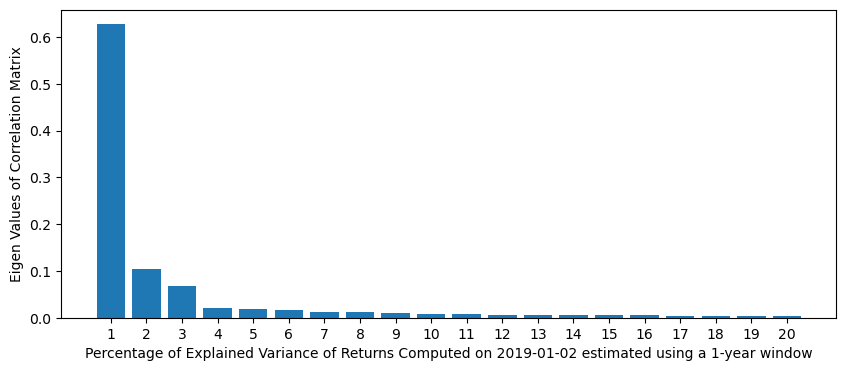

In [8]:
plt.figure(figsize=(10,4))
plt.bar(np.arange(1,21),pca.explained_variance_ratio_[:20])
plt.xticks(np.arange(1,21))
plt.xlabel('Percentage of Explained Variance of Returns Computed on 2019-01-02 estimated using a 1-year window')
plt.ylabel('Eigen Values of Correlation Matrix')
plt.show()

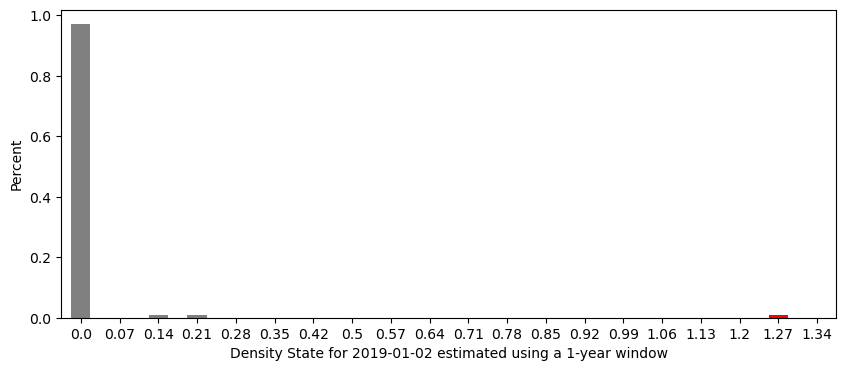

In [9]:
slicing = np.linspace(pca.explained_variance_.min()*0.99,pca.explained_variance_.max(),20)
density_pca = pd.concat([pd.cut(pca.explained_variance_,bins=slicing).describe()['freqs'],pd.Series([0])])
density_pca.index = slicing.round(2)
density_pca.plot.bar(figsize=(10,4),color=['gray']*(len(density_pca)-2)+['red'])
plt.xticks(rotation=0)
plt.ylabel('Percent')
plt.xlabel('Density State for 2019-01-02 estimated using a 1-year window')
plt.show()

### Factor Loadings
**Next, we examine the loadings of each stock under the first three significant components.** We sort the factor loadings in descending orders. In addition, we re-label the chart with the stock's corresponding sector. In this new ordering scheme, we discovery that the neighbors of any company tend to be in the same sector or industry group. For example, companies with the most positive loadings tend to fall under Utilities industry, and the ones with most negative loadings tend to be companies in financial services. 

**This observation agrees with what Dr. Avellaneda's paper calls 'coherence'.** It claims that *"As we descend in the spectrum towards the noise eigenvectors, the property that nearby coefficients correspond to firms in the same industry is less true and coherence will not hold for eigenvectors of the noise spectrum."* Here, we replicate the same exercise for the second and third components.

In [10]:
loadings = pd.DataFrame(pca.components_.T,columns=['PC'+str(i) for i in range(1,len(rho_ij)+1)],index=rho_ij.index)
loadings[['PC1','PC2','PC3']]

,PC1,PC2,PC3
Ticker,,,
AAPL,-0.119862,0.075649,-0.118189
ABBV,-0.062981,-0.092238,-0.057220
ABT,-0.119017,-0.030956,-0.098995
ACN,-0.121058,-0.030977,-0.083931
ADBE,-0.150741,0.132116,-0.170157
...,...,...,...
VZ,0.047491,-0.213420,-0.023701
WBA,-0.041372,-0.098885,-0.018088
WFC,-0.109743,-0.122897,0.134651


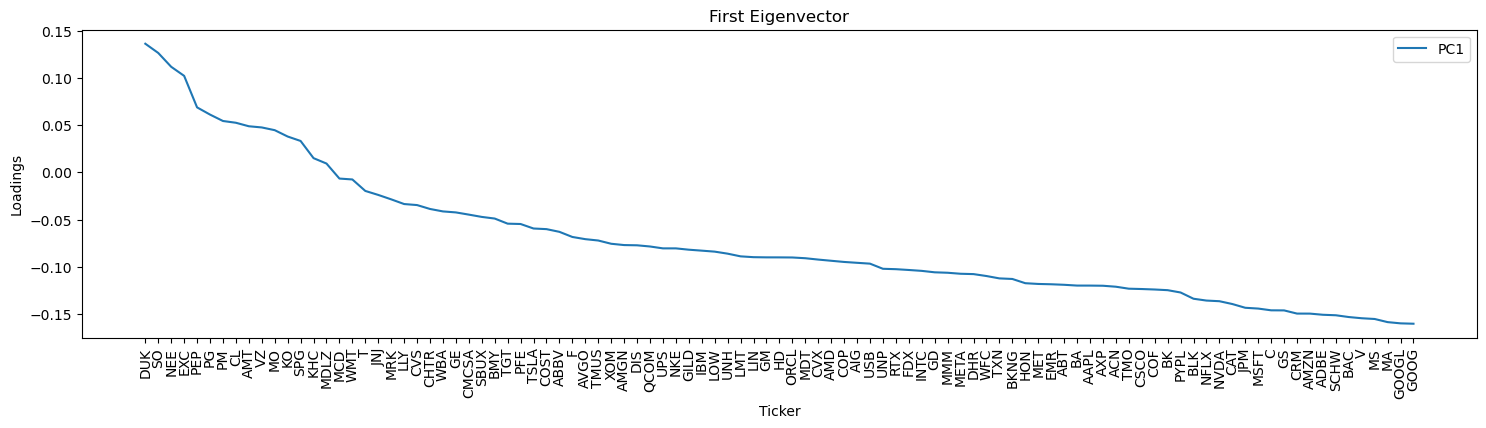

In [11]:
pc1_sort = loadings[['PC1']].sort_values('PC1',ascending=False)
pc1_sort.plot(figsize=(18,4))
plt.xticks(range(len(pc1_sort)),pc1_sort.index,rotation=90)
plt.ylabel('Loadings')
plt.title('First Eigenvector')
plt.show()

**Before we examine different significant components, we offer the sector breakdown of 99 selected stocks in our trading universe.** The most common sector industries are Financial Services, Healthcare, and Technology.

In [12]:
sector_name = pd.read_csv('./data/SP 100 Sector Data.csv')
print(tabulate(sector_name.loc[sector_name['Ticker']!='DOW'].groupby('Sector').count(),headers=['Sector','Count']))

Sector                    Count
----------------------  -------
Basic Materials               1
Communication Services       10
Consumer Cyclical            10
Consumer Defensive           11
Energy                        3
Financial Services           17
Healthcare                   15
Industrials                  12
Real Estate                   2
Technology                   14
Utilities                     4


**As mentioned above, we replace the tickers with their corresponding sector industry.** An interesting observation is the clustering effect of stocks in the same industry. And this is manefested across all three significant components.

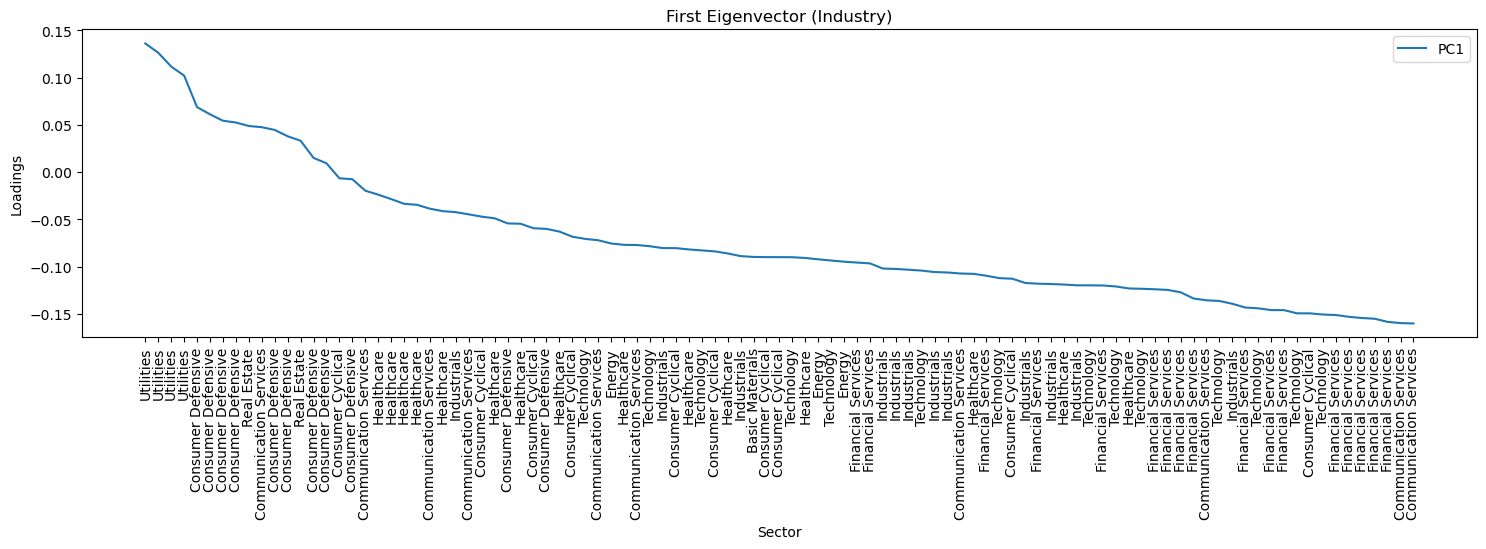

In [13]:
pc1_sort_industry = pc1_sort.merge(sector_name,how='left',left_index=True,right_on='Ticker')[['PC1','Sector']].set_index('Sector')
pc1_sort_industry.plot(figsize=(18,4))
plt.xticks(range(len(pc1_sort_industry)),pc1_sort_industry.index,rotation=90)
plt.ylabel('Loadings')
plt.title('First Eigenvector (Industry)')
plt.show()

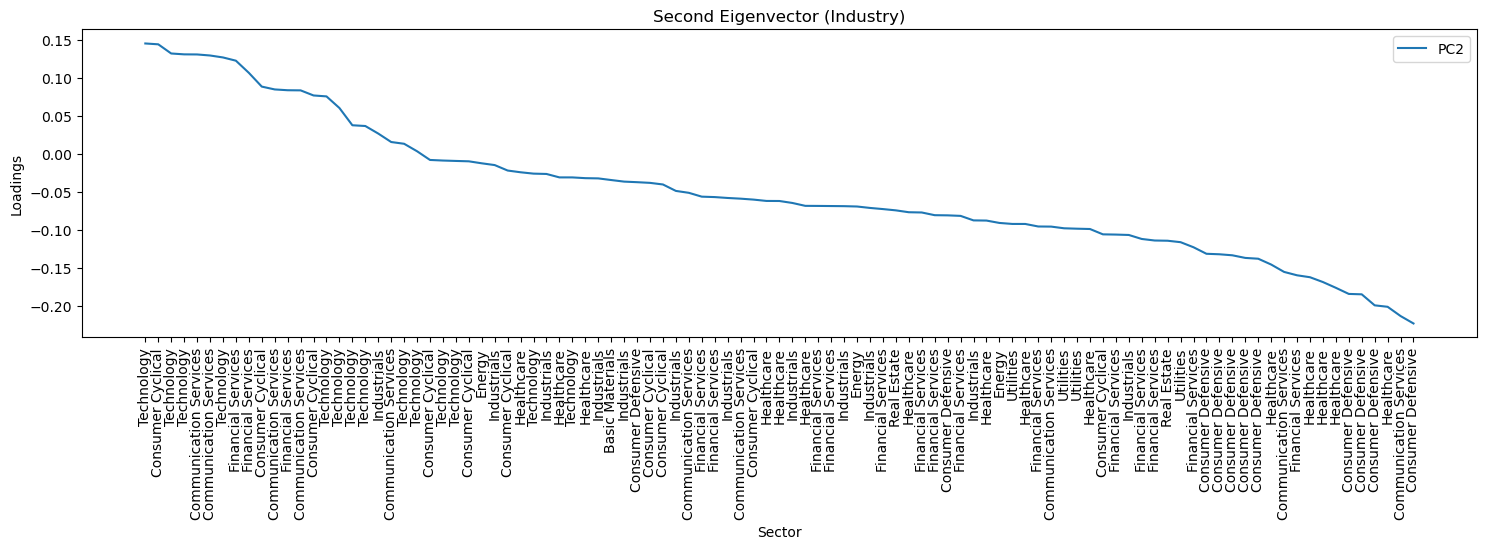

In [14]:
pc2_sort = loadings[['PC2']].sort_values('PC2',ascending=False)
pc2_sort_industry = pc2_sort.merge(sector_name,how='left',left_index=True,right_on='Ticker')[['PC2','Sector']].set_index('Sector')
pc2_sort_industry.plot(figsize=(18,4))
plt.xticks(range(len(pc2_sort_industry)),pc2_sort_industry.index,rotation=90)
plt.ylabel('Loadings')
plt.title('Second Eigenvector (Industry)')
plt.show()

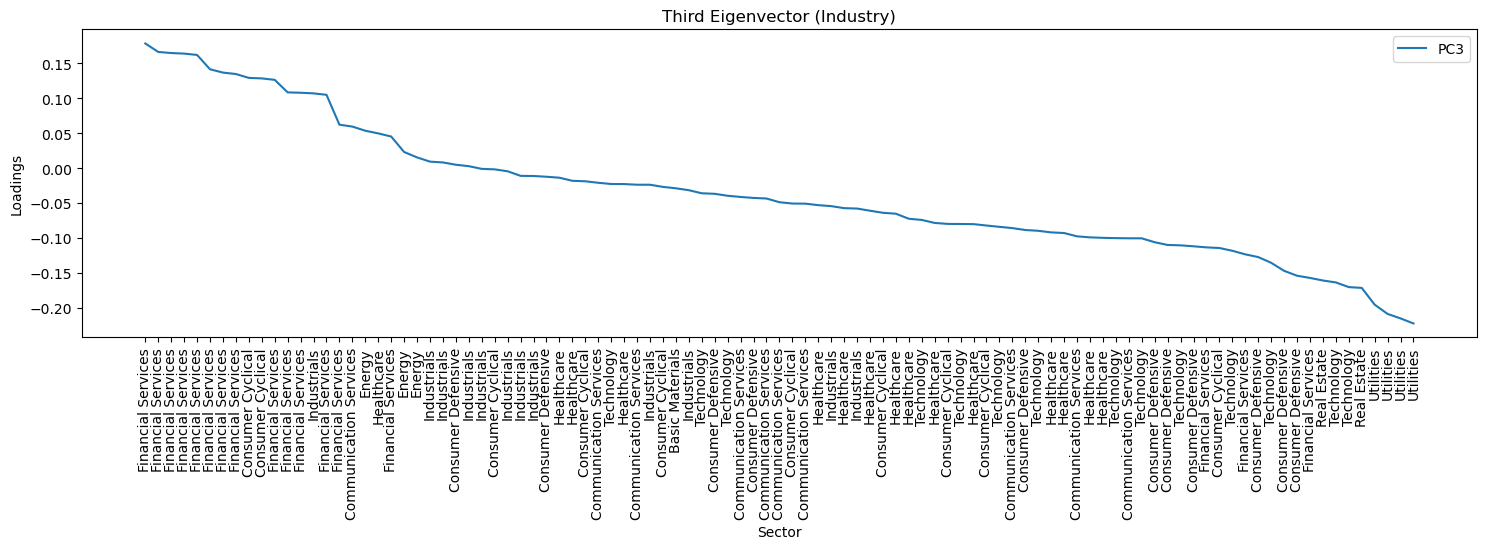

In [15]:
pc3_sort = loadings[['PC3']].sort_values('PC3',ascending=False)
pc3_sort_industry = pc3_sort.merge(sector_name,how='left',left_index=True,right_on='Ticker')[['PC3','Sector']].set_index('Sector')
pc3_sort_industry.plot(figsize=(18,4))
plt.xticks(range(len(pc3_sort_industry)),pc3_sort_industry.index,rotation=90)
plt.ylabel('Loadings')
plt.title('Third Eigenvector (Industry)')
plt.show()

### Eigen Portfolio
**In this section, we construct 3 different eigen portfolios (each represents a significant eigen vector), and compare their performance against a benchmark portfolio.** Typically the choice of benchmark portfolio includes a portfolio weighted by market cap. However, due to the limited free open source on historical market caps (e.g., we do not have credible sources of XOM's market cap on 2018-01-02), we simply use an equal-weight portfolio as benchmark. This is a logical approach, considering the stock selection in our exercise already includes 99 large cap blue chips stocks that are actively traded in the market.

**To determine the weight of each of the stocks for an eigen portfolio, we look at both the loading of a stock for a given eigen vector and the stock's volatility, which was computed in the previous section.** Specifically, the volatility-adjusted loading of a stock for a given eigen vector is defined as following,
$$
Q_{i}^{(j)} =  \frac{v_{i}^{(j)}}{\bar \sigma_{i}},
$$
where $Q_{i}^{j}$ is the volatility-adjusted loading for stock $i$ for eigen vector $j$, <br>
$v_{i}^{(j)}$ is the loading for stock $i$ for eigen vector $j$, and <br>
$\bar \sigma_{i}$ is volatility of the stock, computed before.

The actual weight of a stock for a given eigen vector is then re-scaled such that the sum of weights for all 99 stocks equals to 1.

In [16]:
eigen_weight = loadings[['PC1','PC2','PC3']]
eigen_weight = eigen_weight.div(r_ik_2018.std(),axis=0)
weights = eigen_weight.apply(lambda x: x/x.sum())

print('Sanity Check:')
print(weights.sum())

weights

Sanity Check:
PC1    1.0
PC2    1.0
PC3    1.0
dtype: float64


,PC1,PC2,PC3
Ticker,,,
AAPL,0.016419,-0.010554,0.026377
ABBV,0.007046,0.010509,0.010429
ABT,0.020828,0.005518,0.028226
ACN,0.020515,0.005347,0.023173
ADBE,0.016731,-0.014935,0.030769
...,...,...,...
VZ,-0.009187,0.042047,0.007469
WBA,0.005899,0.014361,0.004202
WFC,0.018433,0.021024,-0.036848


In [17]:
pc1_return = r_ik_2018.multiply(weights['PC1'],axis=1).sum(axis=1)
pc2_return = r_ik_2018.multiply(weights['PC2'],axis=1).sum(axis=1)
pc3_return = r_ik_2018.multiply(weights['PC3'],axis=1).sum(axis=1)
equal_weight_return = r_ik_2018.mean(axis=1)

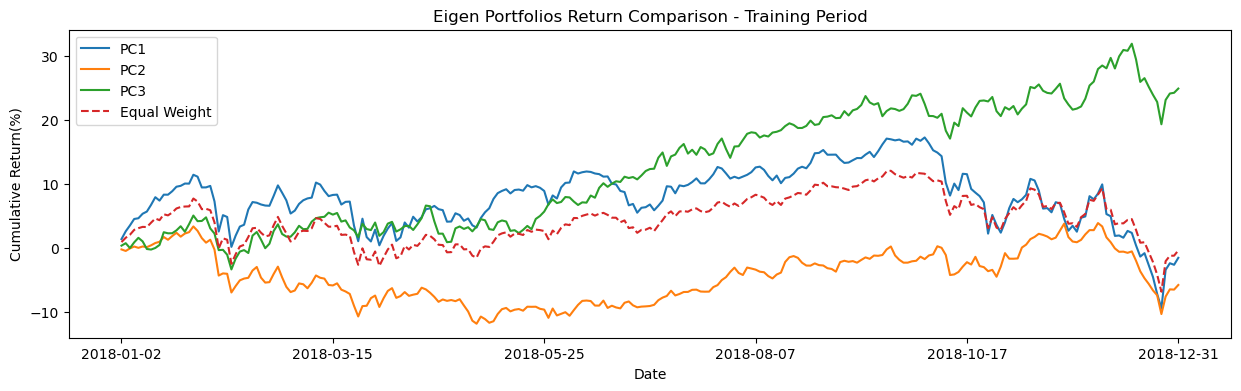

In [18]:
plt.figure(figsize=(15,4))
(pc1_return.cumsum()*100).plot(label='PC1')
(pc2_return.cumsum()*100).plot(label='PC2')
(pc3_return.cumsum()*100).plot(label='PC3')
(equal_weight_return.cumsum()*100).plot(label='Equal Weight',style='--')
plt.legend()
plt.ylabel('Cumulative Return(%)')
plt.title('Eigen Portfolios Return Comparison - Training Period')
plt.show()

**We can observe that the three different eigen portfolios behave similarly as the equally weighted portfolio in terms of PnL shapes, although there are some noticeable discrepencies.** To be more specific, First-Eigen Portfolio seems to be the closest to the benchmark portfolio out of all three. The Third-Eigen Portfolio outperforms all the other portfolios by a wide margin. This makes logical sense, as we recall that in the previous industry analysis, the Third-Eigen Portfolio is more shorting the financial services industry, whereas the other two portfolios are more longing the financial services industry (note that sum of loadings for each eigen vector is negative). In the year 2018, the financial sector had a rough year (10% drop according to Vanguard's Financials Index Fund VFH).

### Simple Trading Strategy
**In this section, we introduce a simple trading strategy that rebalances monthly, based on the eigen portfolio analysis above.** A description of this strategy states as follows,

*We construct a dynamic portfolio that uses PCA to determine the allocation of capital. Specifically, we consider the three most significant principal components, and construct three corresponding eigen portfolios for comparison. We use a one year (or 12 months for execution, in order to align with rebalance frequency) as look back period to perform PCA, and rebalance our portfolios monthly. For example, the specific steps of this strategy go as follows, one should* 
- *use return data between 2010-01-04 and 2010-12-31 as training set for PCA;*
- *derive weight allocation for each stock through the aforementioned approach;*
- *construct such portfolio on 2010-12-31 right before market close*;*
- *hold such a portfolio in the month of Jan 2011;*
- *rebalance the portfolio at the end of Jan 2011, using return data between 2010-02-01 and 2011-01-31. Repeat this process.*


*Note: the assumption here, as many other low frequency strategies, is that we are able to execute such transaction at the same time closing price information is available, which is a big assumption. Alternatively, we can construct the portfolio at market open on 2011-01-01, but there might be significant slippage and price gaps. 

**To extend the backtesting period, we make a few adjustments.** Namely, we cut our trading universe down to 92 stocks and use a backtesting period from 2010-01-04 to 2022-12-30. This adds almost 5 more years of data. Given the nature of this strategy, there is no look ahead bias, and thus every month that we are holding stocks is actually an out-of-sample data point for consideration.

In [19]:
strat_return = pd.read_csv('./pnl/Eigen Portfolio Pnl/SP 100/Backtesting Return_12mo_rolling.csv',index_col=0)
strat_return.dropna(inplace=True)

**Below is the return comparison of such strategy for PC1, PC2, and PC3, as well as a benchmark portfolio with equal weight.** It's not difficult to see that PC1 portfolio behaves almost identically as the equally weighted benchmark, suggesting that the first component is a decent predictor of next period return. This also suggests that purely from a return's perspective, an equally weighted portfolio does not seem to lose any insight on the correlation of these selected stocks.

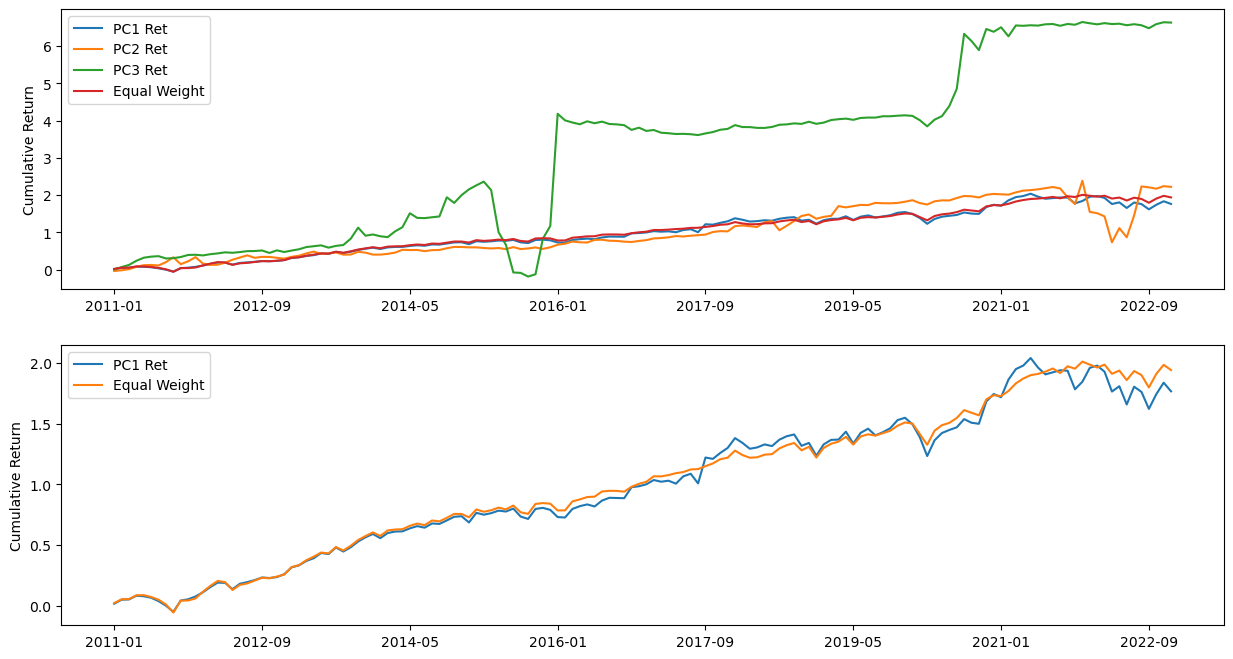

In [20]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
strat_return.cumsum().plot(ax=ax[0])
strat_return[['PC1 Ret','Equal Weight']].cumsum().plot(ax=ax[1])
ax[0].set_ylabel('Cumulative Return')
ax[1].set_ylabel('Cumulative Return')
plt.show()

**We also notice that PC2 and PC3, especially PC3, have volatile returns and much higher drawdowns.** This could be coming from extreme magnitude of loadings for a handful of stocks during a certain period. To examine this, we dig deeper into the weightings of stocks for each strategy over time. Specifically, we will group the weights into different buckets by their values. This will tell us whether we are leveraging too much in our portfolios by shorting a large number of stocks. For example, if the weight of a stock at given time is greater than 100%, we know that this strategy must have heavily shorted a list of other stocks in order to have the capital to allocate into this stock.

In [21]:
strat_weight = pd.read_csv('./pnl/Eigen Portfolio Pnl/SP 100/Backtesting Weight_12mo_rolling.csv',index_col=0)

In [22]:
strat_weight['Weight Bucket'] = pd.cut(strat_weight['Weight'],[-np.inf,-1,-0.1,0,0.1,1,np.inf],
                                      labels=['<-100%','between -100% and -10%','between -10% and 0%',
                                       'between 0% and 10%','between 10% and 100%','>100%'])

**We use the heatmaps below to explain the return variance above.** It is clear that PC1 strategy maintains a mostly long portfolio, with relatively a low number of shorted stocks (with a few exceptions in 2017-07). The same conclusion can not be said about PC2 and PC3 strategies, where high leverage occurs very often (especially PC3 strategy). We also note that relatively high leverage and volatile returns seem to coincide for PC2 and PC3 strategies. For example, there is an extreme drawdown and bounce back in PC3 strategy in late 2014 and 2015 from the above PnL chart. During this time, we notice that there is also extreme weight distribution, with a handful of individual stocks over 100% portfolio weights in absolute terms. This causes the high volatility of returns in each strategy.

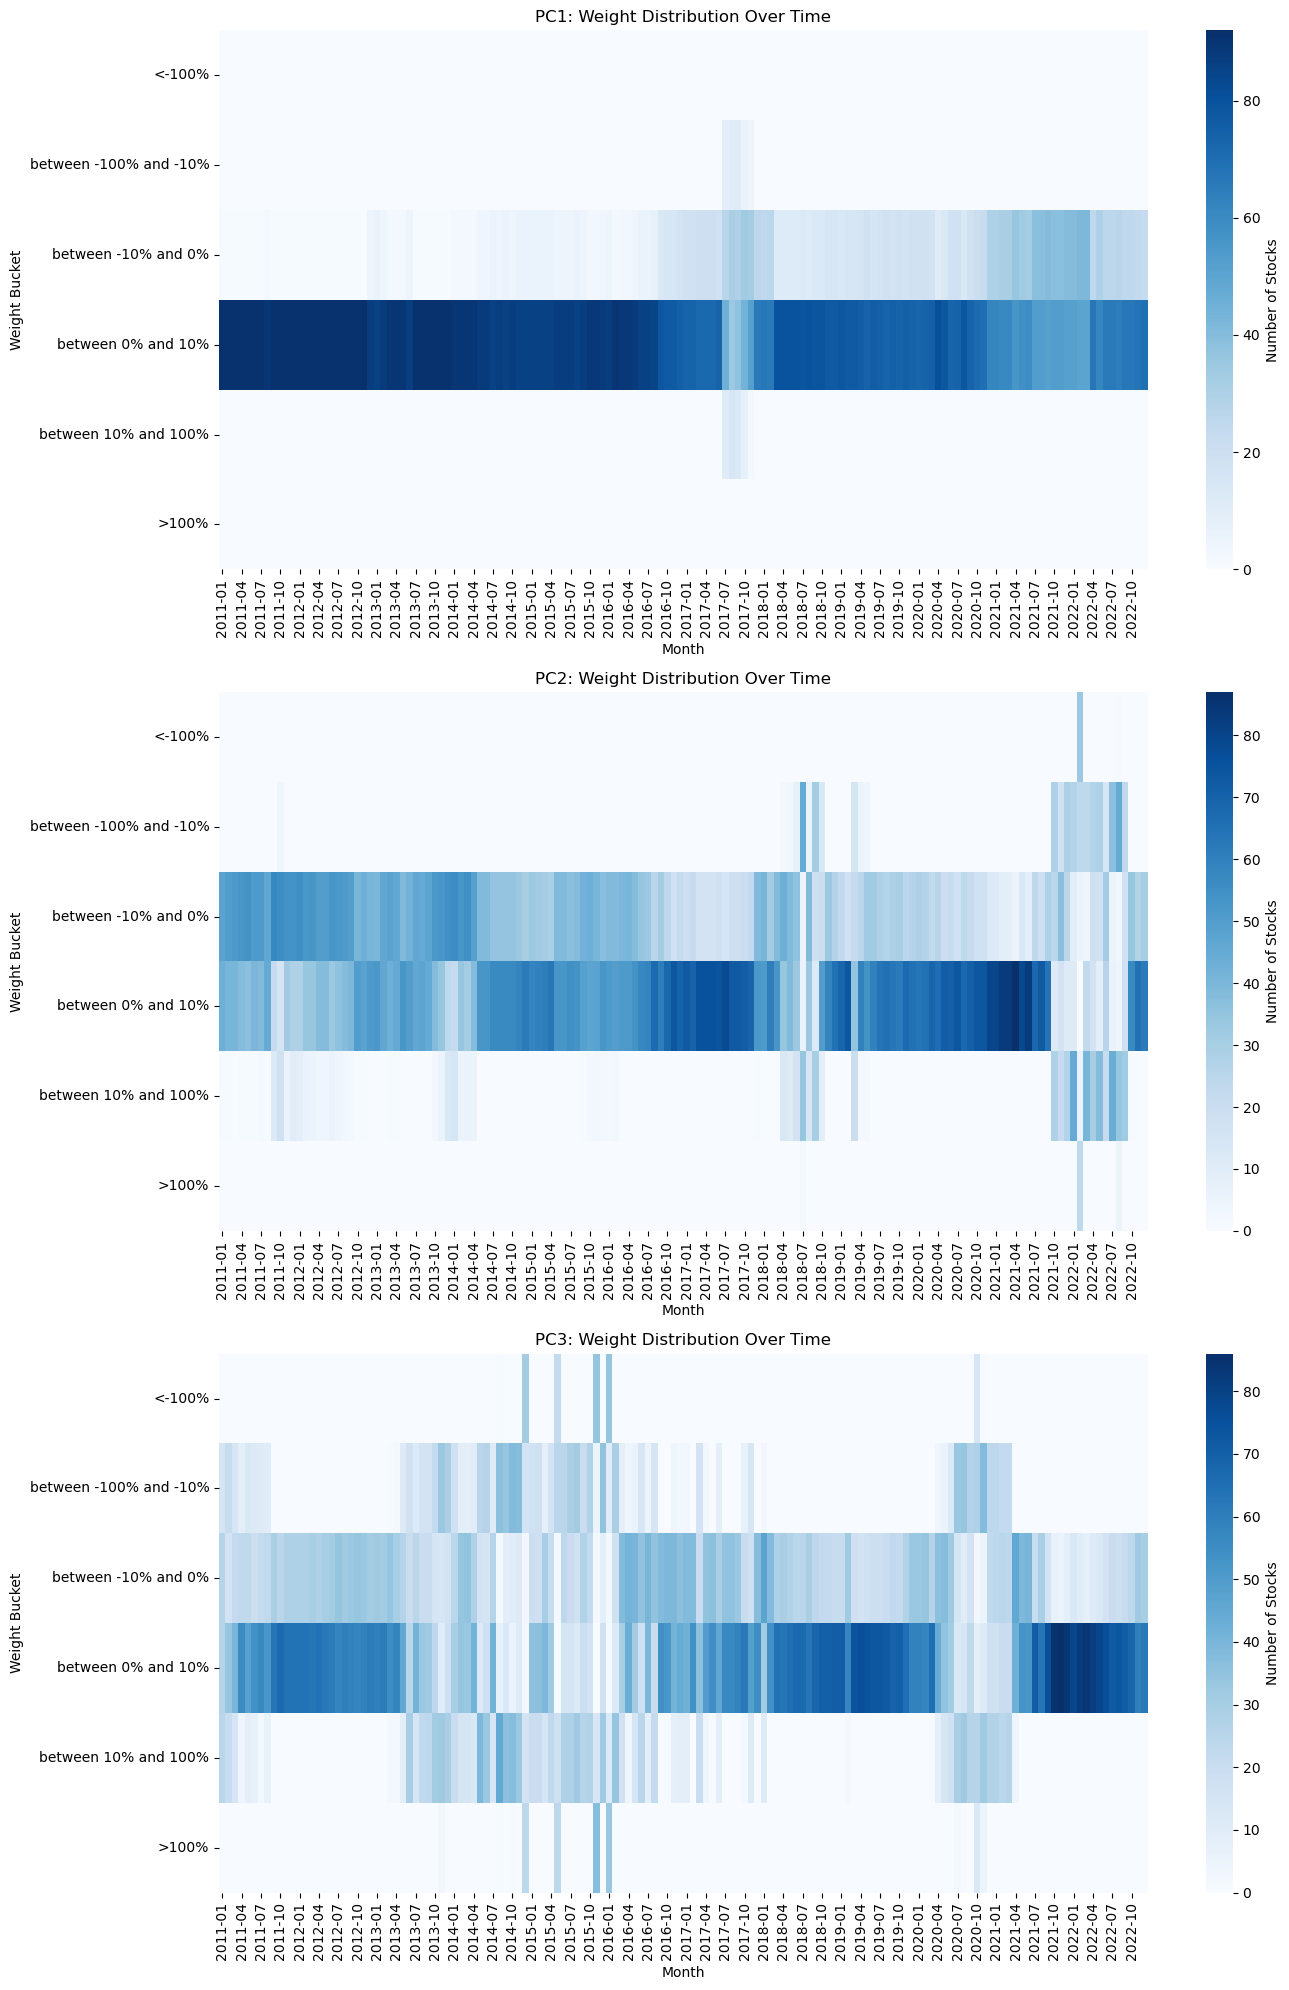

In [23]:
fig,ax= plt.subplots(3,1,figsize=(14,20))
sns.heatmap(strat_weight.loc[strat_weight['PC']=='PC1'].pivot_table(columns='Month',
                                                                    index='Weight Bucket',values='Ticker',aggfunc='count'),
                    cbar_kws={'label': 'Number of Stocks'},ax=ax[0],cmap='Blues')
sns.heatmap(strat_weight.loc[strat_weight['PC']=='PC2'].pivot_table(columns='Month',
                                                                    index='Weight Bucket',values='Ticker',aggfunc='count'),
                    cbar_kws={'label': 'Number of Stocks'},ax=ax[1],cmap='Blues')
sns.heatmap(strat_weight.loc[strat_weight['PC']=='PC3'].pivot_table(columns='Month',
                                                                    index='Weight Bucket',values='Ticker',aggfunc='count'),
                    cbar_kws={'label': 'Number of Stocks'},ax=ax[2],cmap='Blues')
ax[0].set_title('PC1: Weight Distribution Over Time')
ax[1].set_title('PC2: Weight Distribution Over Time')
ax[2].set_title('PC3: Weight Distribution Over Time')
plt.tight_layout()
plt.show()

**Lastly, we offer a few more performance metrics for all three portfolios as well as the benchmark.** Although we can use PCA to cluster stocks and explore more nuances in our trading universe, an equally weighted portfolio seems to outperform eigen portfolios. Additional parameter optimization can be performed on the following variables: Look back period (currently 1 year in this exercise), holding period (currently 1 month in this exercise), and restriction on single stock concentration (e.g., a single stock cannot compose more than +/- 5% of eigen portfolio).

In [30]:
pc1 = performance.Trading_Strategy(strat_return[['PC1 Ret']].reset_index().rename(
    {'index':'date','PC1 Ret':'return'},axis=1),freq='Monthly')
pc1_metrics = pc1.get_metrics().rename({'Value':'PC1'},axis=1)

pc2 = performance.Trading_Strategy(strat_return[['PC2 Ret']].reset_index().rename(
    {'index':'date','PC2 Ret':'return'},axis=1),freq='Monthly')
pc2_metrics = pc2.get_metrics().rename({'Value':'PC2'},axis=1)

pc3 = performance.Trading_Strategy(strat_return[['PC3 Ret']].reset_index().rename(
    {'index':'date','PC3 Ret':'return'},axis=1),freq='Monthly')
pc3_metrics = pc3.get_metrics().rename({'Value':'PC3'},axis=1)

bm = performance.Trading_Strategy(strat_return[['Equal Weight']].reset_index().rename(
    {'index':'date','Equal Weight':'return'},axis=1),freq='Monthly')
bm_metrics = bm.get_metrics().rename({'Value':'Equal Weight'},axis=1)

print(tabulate(pd.concat([pc1_metrics,pc2_metrics,pc3_metrics,bm_metrics],axis=1),
               headers='keys', tablefmt='rst',stralign='center'))

=====================  ========  ========  ========  ==============
         ..              PC1       PC2       PC3      Equal Weight
=====================  ========  ========  ========  ==============
        From           2011-01   2011-01   2011-01      2011-01
         To            2022-12   2022-12   2022-12      2022-12
  Annualized Sharpe     0.7009    0.3523   0.47863      1.14861
 Annualized Sortino    0.93909   0.36223   0.89477      1.65682
  Cumulative Return    1.76491   2.22283   6.62821      1.93988
     Avg Return        0.01226   0.01544   0.04603      0.01347
       Avg Win         0.04492   0.07285   0.14523      0.03398
      Avg Loss         -0.04731  -0.07219  -0.09689     -0.03314
      Win Ratio        0.64583   0.60417   0.59028      0.69444
     Max Winner        0.21284   0.77982   3.00888      0.13121
      Max Loser        -0.16347  -0.83532  -1.12749     -0.10185
   Time in Market        nan       nan       nan          nan
    Max Drawdown       -0.137